[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](TBD)

# Step 6: Machine Learning - Parameter Search / Optimization

In this step we are performing a GridSearch on the binary classification problem. Our considered metric: the F1 score!

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Now we add a binary classification schema, where we distinguish between e.g., X and non-X classes
asteroids_df.loc[:, "Class"] = asteroids_df["Main_Group"].apply(lambda x: 1 if x=="X" else 0)

In [5]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Class"].to_list())

In [6]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

# Compute class weightning
positive_class_weight = int(1.0 / (sum(y_train) / len(X_train)))

In [7]:
# Perform now a GridSearch with the following parameter range and kernels
param_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100], 'kernel': ['rbf']},
 ]

# Set the SVM classifier
svc = svm.SVC(class_weight={1: positive_class_weight})

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Set the GridSearch and ...
wclf = GridSearchCV(svc, param_grid, scoring='f1', verbose=3, cv=5)

# ... perform the training!
wclf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.524 total time=   0.0s
[CV 2/5] END ................C=1, kernel=linear;, score=0.553 total time=   0.0s
[CV 3/5] END ................C=1, kernel=linear;, score=0.519 total time=   0.0s
[CV 4/5] END ................C=1, kernel=linear;, score=0.533 total time=   0.0s
[CV 5/5] END ................C=1, kernel=linear;, score=0.565 total time=   0.0s
[CV 1/5] END ...............C=10, kernel=linear;, score=0.520 total time=   0.2s
[CV 2/5] END ...............C=10, kernel=linear;, score=0.555 total time=   0.2s
[CV 3/5] END ...............C=10, kernel=linear;, score=0.532 total time=   0.2s
[CV 4/5] END ...............C=10, kernel=linear;, score=0.525 total time=   0.2s
[CV 5/5] END ...............C=10, kernel=linear;, score=0.587 total time=   0.2s
[CV 1/5] END ..............C=100, kernel=linear;, score=0.525 total time=   1.8s
[CV 2/5] END ..............C=100, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(class_weight={1: 5}),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'kernel': ['rbf']}],
             scoring='f1', verbose=3)

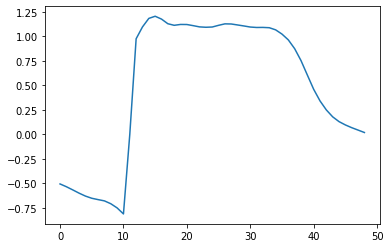

In [10]:
import matplotlib.pyplot as plt

plt.plot(X_train_scaled[1])

In [8]:
# Optional: get the best estimator
final_clf = wclf.best_estimator_

In [9]:
# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# ... and perform a predicition
y_test_pred = final_clf.predict(X_test_scaled)

In [10]:
# Import the confusion matrix and perform the computation
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

print(conf_mat)

# The order of the confusion matrix is:
#     - true negative (top left, tn)
#     - false positive (top right, fp)
#     - false negative (bottom left, fn)
#     - true positive (bottom right, tp)
tn, fp, fn, tp = conf_mat.ravel()

[[218   3]
 [  0  47]]


In [11]:
# Recall: ratio of correctly classified X Class spectra, considering the false negatives
# (recall = tp / (tp + fn))
recall_score = round(sklearn.metrics.recall_score(y_test, y_test_pred), 3)
print(f"Recall Score: {recall_score}")

# Precision: ratio of correctly classified X Class spectra, considering the false positives
# (precision = tp / (tp + fp))
precision_score = round(sklearn.metrics.precision_score(y_test, y_test_pred), 3)
print(f"Precision Score: {precision_score}")

# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred), 3)
print(f"F1 Score: {f1_score}")

Recall Score: 1.0
Precision Score: 0.94
F1 Score: 0.969


# Summary / Outlook:

To finalize: Apply all data (take care of scaling!) on the training and rerun it. Save it afterwards for further computations. Storing and using a model requires also to store the corresponding scaler (store them as pickle files)!

Further notes:<br>
- If you would like to improve the model later on, one needs to perform "partial fits" to improve / train the weight(s). A simple "fit" re-runs the training and computes the model from scratch. Only linear SVMs can be partially fitted using [SGDClassifiers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- Using all data to train a final model requires a proper metric. Cross validation as shown above can be used, but one should consider "Nested Cross Validation" methods as shown [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)
- Also: a computational more extensive method called [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV) may improve the model even further